In [27]:
'''
Modules
'''
# NN Section
import torch
import torch.nn as nn
import torch.nn.functional as F

# Optimizer
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

## Data Loading and Processing Section
import sys
import json
import scipy.io as sio
import numpy as np
import os

# Plotting Section
import matplotlib.pyplot as plt
#from matplotlib.cm import get_cmap
import seaborn as sns
# Metrics
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
from sklearn.manifold import TSNE
from scipy.stats import sem
from sklearn.utils import resample

%matplotlib inline

# Misc
import random 
import math

### Data Loader

In [34]:
'''
Data Loader 
Input:
    - sample_down   : if sampling down the binary labels to be of the same quantity
Output:
    - embeddings    : [num_sentences, max_num_words, hidden_size]
    - EEG           : [num_sentences, max_num_words, eeg_feature_size = 5460]
    - gaze_features : [num_sentences, max_num_words, num_measure_mode = 12]
    - labels        : [num_sentences, max_num_words]
    - sen_len       : [num_sentences]
'''
def load_data(downsample = False, subIdx = 0, datapath = './Datasets/'):
    # List of Subject Names
    subject_name_list = ['ZAB', 'ZDM', 'ZDN', 'ZJM', 'ZJN', 'ZJS', 'ZKH', 'ZKW', 'ZMG']
    
    # Word Embeddings with padding
    em_data = sio.loadmat(os.path.join(datapath, 'wordEmbeddingAll.mat'))['wordEmbeddingAll'].squeeze() # (358, )
    
    sen_len_em = [m.shape[0] for m in em_data]
    max_num_words_em = max(sen_len_em)
    em_size = em_data[0].shape[1]
    embeddings = torch.zeros((len(em_data), max_num_words_em, em_size), dtype = torch.float32)
    
    for i, m in enumerate(em_data):
        n_words = m.shape[0]
        # Add Positional Encoding ???
        embeddings[i, : n_words] = torch.from_numpy(m)

    ########################################
    # EEG Feature Data with padding
    #EEG_path = data_path + 'EEG_data/EEGEmbeddingAll_' + subject_name_list[subIdx] + '.mat'
    EEG_path = os.path.join(datapath, 'EEG_data', 'EEGEmbeddingAll_' + subject_name_list[subIdx] + '.mat')
    eeg_data = sio.loadmat(EEG_path)['EEGEmbeddingAll'].squeeze() # (358,)

    sen_len_eeg = [len(m) for m in eeg_data]
    max_num_words_eeg = max(sen_len_eeg)
    for i, sen in enumerate(eeg_data):
        if sen[0][0].shape[0] > 1:
            eeg_feat_size = sen[0][0].shape[0]
    
    eeg_features = torch.zeros((len(eeg_data), max_num_words_eeg, eeg_feat_size), dtype = torch.float32)

    for i, sen in enumerate(eeg_data):
        for j, word in enumerate(sen):
            if word[0].shape[0] > 1:
                eeg_features[i, j, :] = torch.from_numpy(word[0].squeeze())
    ########################################    
    # Eye Gaze Data with padding
    #EGD_path = './Data/subject_data/eyeGazeData_' + subject_name_list[subIdx] + '.json'
    EGD_path = os.path.join(datapath, 'subject_data', 'eyeGazeData_' + subject_name_list[subIdx] + '.json')
    with open(EGD_path) as file:
        eg_data = json.load(file)

    sen_len_eg = [len(d) for d in eg_data]
    max_num_words_eg = max(sen_len_eg)
    gaze_features = torch.zeros((len(eg_data), max_num_words_eg, 12), dtype = torch.float32)

    # Extract data from the json data
    for i, sentence in enumerate(eg_data):
      for j, word in enumerate(sentence): ## Sentence length / num_word per sentence may vary
        gaze_features[i, j, 0] = word['nFixations']
        gaze_features[i, j, 1] = word['meanPupilSize']
        gaze_features[i, j, 2] = word['FFD']
        gaze_features[i, j, 3] = word['FFD_pupilsize']
        gaze_features[i, j, 4] = word['TRT']
        gaze_features[i, j, 5] = word['TRT_pupilsize']
        gaze_features[i, j, 6] = word['GD']
        gaze_features[i, j, 7] = word['GD_pupilsize']
        gaze_features[i, j, 8] = word['GPT']
        gaze_features[i, j, 9] = word['GPT_pupilsize']
        gaze_features[i, j, 10] = word['SFD']
        gaze_features[i, j, 11] = word['SFD_pupilsize']
          
    ########################################   
    # Labels with padding
    with open(os.path.join(datapath, 'logicVectors.json')) as file:
        lb_data = json.load(file)

    sen_len_lb = [len(d) for d in lb_data]
    max_num_words_lb = max(sen_len_lb)
    labels = torch.zeros((len(lb_data), max_num_words_lb), dtype = torch.float32)
    
    for i, sentence in enumerate(lb_data):
        n_words = len(sentence)
        labels[i, :n_words] = torch.tensor(sentence)

    ########################################   
    if downsample:
        return down_sample([embeddings, eeg_features, gaze_features, labels, torch.tensor(sen_len_em)])
        '''
        # Convert the padded tensors back to list of torch.tensors (without padding)
        em_list = [d[:l] for d, l in zip(embeddings, sen_len_em)] # Word Embedding
        eg_list = [d[:l] for d, l in zip(gaze_features, sen_len_eg)] # Eye Gaze Data
        lb_list = [d[:l] for d, l in zip(labels, sen_len_lb)] # Labels

        down_sampled_em = []
        down_sampled_eg = []
        down_sampled_lb = []
        
        # Sampling Down the Binary Labels to be of the same quantity
        # Count the total number of 0s and 1s in the labels
        n_ones = sum(sum(sentence) for sentence in lb_data)
        n_zeros = sum(l - sum(sentence) for sentence, l in zip(lb_data, sen_len_lb))
        # The down sampling rate for 0s
        rate = n_ones / n_zeros

        # DownSample each tensor in the list by seletively removing 0s
        for i, sentence in enumerate(lb_list):
            # indices of zeros
            zero_indices = torch.where(0 == sentence)[0]
            # randomly select a subset of zero indices to keep
            zeros2keep = int(len(zero_indices) * rate)
            kept_zero_indices = torch.tensor(
                                    np.random.choice(zero_indices, zeros2keep, replace = False)
                                )

            # Mask for elements to keep
            mask = torch.full(sentence.shape, False, dtype = bool)
            mask[1 == sentence] = True
            mask[kept_zero_indices] = True

            # Append the downsampled data
            down_sampled_em.append(em_list[i][mask])
            down_sampled_eg.append(eg_list[i][mask])
            down_sampled_lb.append(lb_list[i][mask])

        # Padding to convert lists back to tensors
        # Word Embedding
        sen_len_em = [m.shape[0] for m in down_sampled_em]
        max_num_words_em = max(sen_len_em)
        em_size = down_sampled_em[0].shape[1]
        embeddings = torch.zeros((len(down_sampled_em), max_num_words_em, em_size), dtype = torch.float32)
        
        for i, m in enumerate(down_sampled_em):
            n_words = m.shape[0]
            embeddings[i, : n_words] = m
            
        # Eye Gaze Data 
        sen_len_eg = [len(d) for d in down_sampled_eg]
        max_num_words_eg = max(sen_len_eg)
        gaze_features = torch.zeros((len(down_sampled_eg), max_num_words_eg, 12), dtype = torch.float32)

        for i, m in enumerate(down_sampled_eg):
            n_words = m.shape[0]
            gaze_features[i, :n_words] = m
            
        # Label
        sen_len_lb = [len(d) for d in down_sampled_lb]
        max_num_words_lb = max(sen_len_lb)
        labels = torch.zeros((len(down_sampled_lb), max_num_words_lb), dtype = torch.float32)

        for i, lb in enumerate(down_sampled_lb):
            n_words = len(lb)
            labels[i, :n_words] = lb
        '''
        
    return [embeddings, eeg_features, gaze_features, labels, torch.tensor(sen_len_em)]

In [35]:
def down_sample(data):
    '''
    Down Sample tensors
    [embeddings, gaze_features, labels, torch.tensor(sen_len_em)]
    1. Remove Padding in each tensor
    2. DownSample the labels
    3. Create Mask
    4. DownSample other tensors using the Mask
    5. Pad
    '''
    sen_len = data[-1]
    labels = data[-2]
    # 1. Remove Paddings: list of tensors for each original tensor
    data_lists = [[d[:l] for d, l in zip(tensor, sen_len)] for tensor in data[:-1]]

    downsampled_lists = [[] for _ in range(len(data[:-1]))]
    
    # 2. Down Sample the Labels
    n_ones = sum(sum(sentence) for sentence in labels)
    n_zeros = sum(l - sum(sentence) for sentence, l in zip(labels, sen_len))
    # The down sampling rate for 0s
    rate = n_ones / n_zeros

    # 3. Creating Mask for each sentence
    for i, sentence in enumerate(data_lists[-1]): # labels
        # indices of zeros
        zero_indices = torch.where(0 == sentence)[0]
        # randomly select a subset of zero indices to keep
        if 0 == random.randint(0,1):
            zeros2keep = math.floor(len(zero_indices) * rate)
        else:
            zeros2keep = math.ceil(len(zero_indices) * rate)
        kept_zero_indices = torch.tensor(
                                np.random.choice(zero_indices, zeros2keep, replace = False)
                            )

        # Mask for elements to keep
        mask = torch.full(sentence.shape, False, dtype = bool)
        mask[1 == sentence] = True
        mask[kept_zero_indices] = True

        # 4. Append the downsampled data
        for new_list, old_list in zip(downsampled_lists, data_lists):
            new_list.append(old_list[i][mask])

    # 5. Padding to convert lists back to tensors
    padded_downsampled_data = []
    
    # Embeddings and Features 
    for new_list in downsampled_lists[:-1]:
        new_sen_len = [len(d) for d in new_list]
        new_max_num_words = max(new_sen_len)
        embed_size = new_list[0].shape[1]

        padded_tensor = torch.zeros((len(new_list), new_max_num_words, embed_size), dtype = torch.float32)
        for i, m in enumerate(new_list):
            n_words = m.shape[0]
            padded_tensor[i, :n_words] = m

        padded_downsampled_data.append(padded_tensor)

    # Label
    padded_labels = torch.zeros((len(downsampled_lists[-1]), new_max_num_words), dtype = torch.float32)

    for i, lb in enumerate(downsampled_lists[-1]):
        n_words = len(lb)
        padded_labels[i, :n_words] = lb

    padded_downsampled_data.append(padded_labels)
    padded_downsampled_data.append(torch.tensor(new_sen_len))
    return padded_downsampled_data

----

### Models 

In [4]:
'''
Classifiers as Submodels for plug-and-play
'''
class LinearClassifier(nn.Module):
    '''
    Simple Classifier for High- Low- Relevance Inference

    Input:
        - Reading Embeddings : [n_sentence, n_words, projection_dim]

    Output:
        - Labels             : [n_sentence, n_words]
    '''
    def __init__(self, projection_dim, **kwargs):
        super(LinearClassifier, self).__init__(**kwargs)
        self.linearLayer = nn.Sequential(
                                    nn.Linear(projection_dim, projection_dim // 2),
                                    nn.LeakyReLU(),
                                    nn.Linear(projection_dim // 2, 1),
                                    nn.Sigmoid() 
                                    )

    def forward(self, embeddings):
        return self.linearLayer(embeddings).squeeze(dim = -1)



In [36]:
'''
Positional Encoding for Input Seq in Transformer
'''
def positional_encoding(length, depth, device = 'cpu'):
    ## REFERENCE: https://www.tensorflow.org/text/tutorials/transformer#the_embedding_and_positional_encoding_layer
    # Sinosoidal positional encoding
    half_depth = depth//2 
    #print('half_depth = ', half_depth)
    # Generate a range of positions and depths
    positions = torch.arange(length, device = device).unsqueeze(dim = 1) # (length, 1)
    #print('positions = ', positions)
    depths = torch.arange(half_depth, device = device).unsqueeze(dim = 0) / half_depth # (1, depth)
    #print('depths = ', depths)
    # Compute range of radians to take the sine and cosine of
    angle_rates = 1 / (10000**depths)    # (1, depth)
    #print('angle_rates = ', angle_rates)
    angle_rads = positions * angle_rates # (length, depth)
    #print('angle_rads = ', angle_rads)
    if depth % 2:
        pos_encoding = torch.cat([torch.sin(angle_rads), torch.zeros(len(angle_rads), 1, device = device), torch.cos(angle_rads)], axis = -1).float()
    else:
        pos_encoding = torch.cat([torch.sin(angle_rads), torch.cos(angle_rads)], axis = -1).float()
    return pos_encoding

class PositionalEncoding(nn.Module):
    '''
    Add the Designed Sinosoidal Position-Encodings to the Inputs
    # outputs: [batch_sz, n_words, embedding_size]
    '''
    def __init__(self):
        super(PositionalEncoding, self).__init__()

        #self.n_words = n_words
        #self.embed_size = emb_sz
        self.pos_encoding = positional_encoding #(self.n_words, self.embed_size)

    def forward(self, x):
        # Scale
        embed_size = x.shape[-1]
        n_words = x.shape[-2]
        x *= torch.math.sqrt(float(embed_size))
        # Pos Encoding
        x += self.pos_encoding(n_words, embed_size, x.device).unsqueeze(dim = 0)
        return x

In [37]:
'''
Transformer Section
'''
class AttentionMatrix(nn.Module):
    def __init__(self, *args, use_mask=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.use_mask = use_mask

    def forward(self, inputs):
        '''
        Computes Attention Given key and query matrices.

        Input:
            - K: [batch_size x n_words_keys x embedding_size]
            - Q: [batch_size x n_words_queries x embedding_size]
        Output:
            - Attention Matrix
        '''
        K, Q = inputs
        n_words_queries = Q.shape[1] # window size of queries
        n_words_keys = K.shape[1] # window size of keys
        device = K.device

        ## Fill triangle below diagonal of matrix with negative infinity and top part with 0.
        ## This helps to avoid over-contribution, since adjacency matrix is symmetric across diagonal. 
        ## Tile this upward to be compatible with addition against computed attention scores.

        mask_vals = np.triu(np.ones((n_words_queries)) * np.NINF, k = 1)
        mask = torch.from_numpy(mask_vals).float().to(device)
        atten_mask = torch.tile(torch.reshape(mask,
                                             [-1, n_words_queries, n_words_keys]),
                                             [K.shape[0], 1, 1]) #### Repeat mask along the first dimension / batch
        '''
        Self Attention
        1. compute attention weights using queries and key matrices 
               - if use_mask==True, then make sure to add the attention mask before softmax
        2. return the attention matrix
        
        - Mask: [batch_size x window_size_queries x window_size_keys]
        '''
        weights = torch.einsum('bqe,bke->bqk', Q, K)
        weights /= torch.math.sqrt(float(n_words_keys)) ####

        if self.use_mask:
            weights = torch.add(weights, atten_mask)
        return F.softmax(weights, dim = -1)

class AttentionHead(nn.Module):
    def __init__(self, input_size, output_size, is_self_attention, **kwargs):
        super(AttentionHead, self).__init__(**kwargs)
        self.use_mask = is_self_attention
        self.input_size = input_size
        self.output_size = output_size
        
        # Initialize K, V, Q --- Xavier
        scale = 1.0 / torch.math.sqrt( float(input_size + output_size))
        self.Wk, self.Wv, self.Wq = [nn.Parameter(torch.randn(input_size, output_size) * scale) for _ in range(3)]

        # Attention Matrix Layer
        self.atten_matrix = AttentionMatrix(use_mask = self.use_mask)

    def forward(self, inputs_for_keys, inputs_for_values, inputs_for_queries):
        '''
        Input:
            - inputs_for_keys: [batch_size x KEY_WINDOW_SIZE x input_size ]
            - inputs_for_values: [batch_size x KEY_WINDOW_SIZE x input_size ]
            - param inputs_for_queries: [batch_size x QUERY_WINDOW_SIZE x input_size ]
        Output:
            - [BATCH_SIZE x QUERY_WINDOW_SIZE x output_size]
        '''
        K = torch.einsum('bwi,io->bwo', inputs_for_keys, self.Wk)
        V = torch.einsum('bwi,io->bwo', inputs_for_values, self.Wv)
        Q = torch.einsum('bwi,io->bwo', inputs_for_queries, self.Wq)

        weights = self.atten_matrix([K,Q])
        return torch.einsum('bqk,bko->bqo', weights, V)

class MultiHeadedAttention(nn.Module):
    def __init__(self, emb_sz, use_mask, num_heads, **kwargs):
        super(MultiHeadedAttention, self).__init__(**kwargs)
        self.use_mask = use_mask
        self.num_heads = 3
        self.embed_size = emb_sz
        # **The remainder in features are truncated off**   
        self.head_size = self.embed_size // self.num_heads
        self.atten_heads = nn.ModuleList([AttentionHead(self.head_size, self.head_size, self.use_mask) for i in range(self.num_heads)])
        # Project the concatenated features back to embed_size
        self.linear_layer = nn.Linear(self.head_size * self.num_heads, self.embed_size)
        
    def forward(self, inputs_for_keys, inputs_for_values, inputs_for_queries):
        # Compute Heads
        Heads = torch.cat([head(inputs_for_keys[:, :, i*self.head_size : (i+1)*self.head_size],\
                               inputs_for_values[:, :, i*self.head_size : (i+1)*self.head_size],\
                               inputs_for_queries[:, :, i*self.head_size : (i+1)*self.head_size])\
                          for i,head in enumerate(self.atten_heads)], axis = -1)
        # Project back the concatenated features
        return self.linear_layer(Heads)

class TransformerEncoder(nn.Module):
    '''
    Transformer Encoder Block that reweights the input tensor based on self-attention
    '''
    def __init__(self, emb_sz, MultiHeaded = True, num_heads = 3, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        
        self.embed_size = emb_sz
        self.is_multi_headed = MultiHeaded
        self.num_heads = num_heads
        # Feed Forward Layer
        self.ff_layer = nn.Linear(self.embed_size, self.embed_size)

        self.self_atten = AttentionHead(self.embed_size, self.embed_size, True) if not self.is_multi_headed else MultiHeadedAttention(self.embed_size, True, self.num_heads)
        # Layer Normalization for stable gradients
        self.layer_norm = nn.LayerNorm(self.embed_size)
        
    def forward(self, inputs):
        '''
        1. Masked Self-Attention on the inputs
        2. Residual Connection and Layer Normalization
        3. Feed Forward Layer
        4. Residual Connection and Layer Normalization
        5. return leaky_relu of tensor

        - inputs: [n_sentences, max_n_words, embedding_size]
        - outputs: [n_sentences, max_n_words, embedding_size]
        '''
        # 1
        atten_inputs = self.self_atten(inputs, inputs, inputs)
        # 2
        atten_inputs = atten_inputs + inputs # Residual Part
        atten_inputs = self.layer_norm(atten_inputs)

        # 3
        outputs = self.ff_layer(atten_inputs)
        # 4
        outputs = outputs + atten_inputs # Residual Part
        outputs = self.layer_norm(outputs)
        return F.leaky_relu(outputs)


class TransformerBlocks(nn.Module):
    '''
    - Position Encoding
    - Transfomer Encoder **** Can use multiple tranformer encoders
    - MLP Classifier
    **** Requires number of Words **** 
    '''
    def __init__(self, emb_sz, num_transformer = 1, MultiHeaded = True, num_heads = 3, **kwargs):
        
        super(TransformerBlocks, self).__init__(**kwargs)
        #self.n_words = n_words
        self.embed_size = emb_sz

        # Pos Encoding
        self.pos_encoding = PositionalEncoding()

        # Transformer Encoder
        transformer_blocks = [TransformerEncoder(self.embed_size, MultiHeaded, num_heads) for _ in range(num_transformer)]
        self.encoder = nn.Sequential(*transformer_blocks)

        # Classifier (with sigmoid)
        #self.classifier = LinearClassifier(self.embed_size)

    def forward(self, inputs):
        inputs = self.pos_encoding(inputs)
        probs = self.encoder(inputs)
        return probs

----

In [38]:
'''
The Complete Pipeline of ReadingEmbedding Model
that administrates:
    - Generation of ReadingEmbeddings for words in each sentence
    - Classification of High-Low Relevances for words in each sentence
'''
class ReadingEmbeddingModel(nn.Module):
    '''
    One Reading-Embedding Encoder with a Classifier

    Input:
        - Word Embeddings    : [n_sentences, n_words, embedding_dim] ； ## !!! May need L2-Normalization 
        - EEG                : [num_sentences, max_num_words, eeg_feature_size = 5460] ## L2-Normalization
        - Eye Gaze Features  : [n_sentences, n_words, feature_dim = 12] ## L1-Normalization
    Intermediate Output:
        - Reading Embeddings : [n_sentences, n_words, projection_dim]
    Final Output:
        - Labels             : High- / Low- Relevance [(n_subjects), n_sentences, n_words]
    
    #######################################################################
    Method : 
        - Normalization
        - Project the input to a common space then element-wise addition (reading embeddings)
        - classifier (labels)
    '''
    def __init__(self, word_embedding_dim, eeg_feature_dim, eye_gaze_feature_dim, projection_dim, 
                 n_trans = 1, feat_choice = [1, 1, 1],
                 MultiHeaded = True, num_heads = 3):
        super(ReadingEmbeddingModel, self).__init__()

        self.embed_size = word_embedding_dim
        self.eeg_feature_dim = eeg_feature_dim
        self.eye_gaze_feature_dim = eye_gaze_feature_dim
        self.projection_dim = projection_dim
        
        # Linear layers for projecting embeddings
        self.feat_choice = feat_choice
        we, eeg, eg = feat_choice
        self.word_projection = nn.Linear(word_embedding_dim, projection_dim) if we else lambda x: 0 
        self.eeg_projection = nn.Linear(eeg_feature_dim, projection_dim) if eeg else lambda x: 0
        self.eye_gaze_projection = nn.Linear(eye_gaze_feature_dim, projection_dim) if eg else lambda x: 0

        # Transformer Blocks
        self.encoder = TransformerBlocks(projection_dim, n_trans, MultiHeaded, num_heads)
        # Classifier
        self.classifier = LinearClassifier(self.projection_dim)
            
    #---------------#

    def normalize_l1(self, vecs):
        '''
        Normalize by L1 Norm ******
        (Sum of all Entries in the Second last dimension)

        - vecs : [n_sentences, n_words, feature_dim = 12]
        '''
        magnitudes = vecs.sum(axis = -2, keepdim = True)
        # avoid 0 magnitudes for each feature_dim across words within each sentence
        magnitudes[0 == magnitudes] = 1.0
        return vecs / magnitudes
    
    def normalize_l2(self, vecs):
        '''
        Normalize by L2 Norm
        (Square Root of the Squared sum of all Entries in the last dimension)

        - vecs : [n_sentences, n_words, embedding_dim]
        '''
        magnitudes = torch.sqrt((vecs**2).sum(axis = -1, keepdim = True))
        # avoid 0 magnitudes for each word in each sentence
        magnitudes[0 == magnitudes] = 1.0
        return vecs / magnitudes

    #---------------#
    def get_reading_embeddings(self, word_embeddings, eeg_features, eye_gaze_features):
        # L2 - Normalize word_embeddings
        word_embeddings = self.normalize_l2(word_embeddings)

        # L2 - Normalize EEG features
        eeg_features = self.normalize_l2(eeg_features)

        # L1 - Normalize eye gaze features
        # Softmax across words for each sentence
        eye_gaze_features = self.normalize_l1(eye_gaze_features)
        eye_gaze_features = F.softmax(eye_gaze_features, dim = -2)

        # Project the inputs to a common space
        word_embeddings = self.word_projection(word_embeddings)
        eeg_features = self.eeg_projection(eeg_features)
        eye_gaze_features = self.eye_gaze_projection(eye_gaze_features)
        # Return the element-wise addition as the Reading Embeddings
        return self.encoder(word_embeddings + eeg_features + eye_gaze_features) # [n_sentences, n_words, projection_dim] 

    def forward(self, word_embeddings, eeg_features, eye_gaze_features):
        reading_embeddings = self.get_reading_embeddings(word_embeddings, eeg_features, eye_gaze_features)
        # Return the classifier's results
        return self.classifier(reading_embeddings) # [n_sentences, n_words] 


In [39]:
'''
Metrics
** Consider Masked_BCE_Loss + F1_Score
'''
def relevance_accuracy(y_pred, y_true, sen_lengths):
    '''
    Accuracy between the predicted and the true label
    [n_sentences, n_words] 

    ** the actual sentence length may differ ** 
    '''
    # Threshold the Probabilistic Predicitons to Labels
    binary_pred = y_pred >= 0.5
    y_true = y_true.type_as(binary_pred)

    device = y_true.device

    # Compare
    correctness = (binary_pred == y_true)

    # Mask out the padding according to the given sentence lengths
    max_len = y_true.shape[-1]
    mask = torch.arange(max_len, device = device).expand(len(sen_lengths), max_len) < sen_lengths.unsqueeze(-1)
    acc = correctness.masked_select(mask).float().mean()
    return acc.item()


def masked_bce_loss(y_pred, y_true, sen_lengths):
    '''
    BCE Loss with a Mask for Variable Sententce Lengths
    '''
    device = y_true.device
    max_len = y_true.shape[-1]
    mask = torch.arange(max_len, device = device).expand(len(sen_lengths), max_len) < sen_lengths.unsqueeze(-1)

    masked_preds = y_pred.masked_select(mask)
    masked_labels = y_true.masked_select(mask)

    # BCE for the masked inputs
    loss = F.binary_cross_entropy(masked_preds, masked_labels)

    return loss

def masked_mse_loss(y_pred, y_true, sen_lengths):
    '''
    MSE Loss with a Mask for Variable Sentence Lengths
    '''
    device = y_true.device
    max_len = y_true.shape[-1]
    mask = torch.arange(max_len, device = device).expand(len(sen_lengths), max_len) < sen_lengths.unsqueeze(-1)

    masked_preds = y_pred.masked_select(mask)
    masked_labels = y_true.masked_select(mask)

    squared_diff = (masked_preds - masked_labels) ** 2
    return squared_diff.mean(dim = 0)


def masked_f1_loss(y_pred, y_true, sen_lengths):
    '''
    Soft F1 Loss based on Bray-Curtis Distance
    '''
    device = y_true.device
    max_len = y_true.shape[-1]
    mask = torch.arange(max_len, device = device).expand(len(sen_lengths), max_len) < sen_lengths.unsqueeze(-1)

    masked_preds = y_pred.masked_select(mask).float()
    masked_labels = y_true.masked_select(mask).float()

    # Calculate the TP, TN, FP, FN
    tp = torch.sum(masked_labels * masked_preds, dim = 0)
    tn = torch.sum((1 - masked_labels) * (1 - masked_preds), dim = 0)
    fp = torch.sum((1 - masked_labels) * masked_preds, dim = 0)
    fn = torch.sum(masked_labels * (1 - masked_preds), dim = 0)

    # Precesion and Recall
    p = tp / (tp + fp + 1e-7)
    r = tp / (tp + fn + 1e-7)

    # F1 Score
    f1 = 2 * p * r / (p + r + 1e-7)
    f1 = torch.where(torch.isnan(f1), torch.zeros_like(f1), f1)
    return 1 - torch.mean(f1)

def total_loss(y_pred, y_true, sen_lengths):
    '''
    Total Loss consisting of Masked-:
    - BCE Loss:
    - MSE Loss:
    - F1 Loss:
    '''
    m_bce = masked_bce_loss(y_pred, y_true, sen_lengths)
    m_mse = masked_mse_loss(y_pred, y_true, sen_lengths)
    m_f1 = masked_f1_loss(y_pred, y_true, sen_lengths)
    return m_bce + m_mse + m_f1

def f1_by_cm(cm):
    TP = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]
    TN = cm[1,1]
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1

## Train and Test Methods

In [40]:
'''
Train and Test Section
'''
## Training Subroutines ##

def train_step(model, 
               train_data, 
               metrics, optimizer):
    '''
    The Generic Train Step for a Trainable Model

    Input:
        - model     : 
        - train_data:
            - word_embeddings         : Input data [n_sentences, n_words, embedding_dim]
            - eeg_features            : Input data [num_sentences, max_num_words, eeg_feature_size = 5460]
            - gaze_features           : Input data [n_sentences, n_words, feature_dim = 12]
            - true_labels             : Ground Truth [n_sentences, n_words] 
            - sen_lengths             : Sentence Lengths [n_sentences]
        - metrics   : [loss_func, acc_func]
        - optimizer :

    Output:
        - loss      :
        - acc       :
    '''
    model.train()
    # Unpacking
    word_embeddings, eeg_features, gaze_features, true_labels, sen_lengths = train_data
    loss_func, acc_func = metrics

    # Forward Pass
    predictions = model(word_embeddings, eeg_features, gaze_features)

    # Loss calculation
    loss = loss_func(predictions, true_labels, sen_lengths)
    
    # Backward Pass
    optimizer.zero_grad() # clear the gradient
    loss.backward()
    optimizer.step()

    # Calculate the acc ######## acc after the backward pass
    with torch.no_grad():
        model.eval()
        updated_preds = model(word_embeddings, eeg_features, gaze_features)
        acc = acc_func(updated_preds, true_labels, sen_lengths)
        model.train()
    return loss.clone().detach(), acc

def shuffle_embeddings(train_data):
    '''
    Shuffle the inputs and the labels
    Input:
        - word_embeddings : [n_sentences, n_words, embedding_dim]
        - eeg_features    : [num_sentences, max_num_words, eeg_feature_size = 5460]
        - gaze_features   : [n_sentences, n_words, feature_dim = 12]
        - true_labels     : [n_sentences, n_words] 
        - sen_lengths     : [n_sentences]
    '''
    #indices = torch.randperm(true_labels.shape[0])
    #return word_embeddings[indices], gaze_features[indices], true_labels[indices]
    indices = torch.randperm(train_data[-2].shape[0])
    #print('shuffled indices length:', len(indices))
    return [data[indices] for data in train_data]


def train_model(model, batch_size, epochs,
                train_data, test_data, downsample = True,
                metrics = [total_loss, relevance_accuracy],
                opt_type = 'SGD',
                lr = 0.05, min_lr = -1):
    '''
    The Overall Train Method for the Model

    Input:
        - model           :
        - batch_size      : number of sentences used for training
        - epochs          : number of the total epochs
        - train_data      :
            - word_embeddings : [n_sentences, n_words, embedding_dim]
            - eeg_features    : [num_sentences, max_num_words, eeg_feature_size = 5460]
            - gaze_features   : [n_sentences, n_words, feature_dim = 12]
            - true_labels: [n_sentences, n_words] 
            - sen_lengths: [n_sentences]

        - test_data       :
        - downsample      : if downsampling the train data
        - metrics         : [loss_func, acc_func]
        - opt_type        : SGD or Adam (maybe second order optimizer e.g. L-BFGS )
        - lr              : learning rate 
        - min_lr          : minimum lr for learning-rate scheduler; do not use scheduler if min_lr = -1

    Output:
        - loss_list       : batch losses
        - acc_list        :
    '''
    loss_list = []
    acc_list = []

    #word_embeddings, eeg_features, gaze_features, true_labels, sen_lengths = train_data

    # Define optimizers *** Adam By Default
    if 'SGD' == opt_type:
        opt = optim.SGD(model.parameters(), lr = lr)
    elif 'Adam' == opt_type:
        opt = optim.Adam(model.parameters(), lr = lr)
    else:
        raise ValueError(f'opt_type = {opt_type} not yet supported.')
        
    # (Optional) Learning Rate Scheduler 
    if -1 != min_lr:
        scheduler = CosineAnnealingLR(opt, T_max = epochs, eta_min = min_lr)

    n_sentences = len(train_data[-1])
    n_batches = n_sentences // batch_size
    # For each epoch
    for e in range(epochs + 1):
        # shuffle the whole input
        shuffled_data = shuffle_embeddings(train_data)
        if downsample:
            shuffled_data = down_sample(shuffled_data)
        # Batch the input 
        for startIdx in range(0, n_sentences, batch_size):
            #curr_WE = WE[startIdx: startIdx + batch_size]
            #curr_GF = GF[startIdx: startIdx + batch_size]
            #curr_TL = TL[startIdx: startIdx + batch_size]
            #curr_SL = SL[startIdx: startIdx + batch_size]
            curr_batch = [d[startIdx: startIdx + batch_size] for d in shuffled_data]
            loss, acc = train_step(model,
                                   curr_batch, 
                                   metrics, opt)
            # record the results
            loss_list.append(loss)
            acc_list.append(acc)

        if -1 != min_lr:
            scheduler.step()
        # Every 10 Epoch: Print out last batch loss and test loss
        if 0 == e % 10:
            test_loss, test_acc, cm, test_f1, (preds, labels, valid_indices) = test_step(model,
                                  test_data,
                                  metrics)
            
            print(f"\r[At Epoch{e}]: \t-- LastBatchLoss: {loss:.4f}, LastBatchAcc: {acc:.4f}, TestLoss: {test_loss:.4f}, TestAcc: {test_acc:.4f}, TestF1: {test_f1:.4f}", end = '')

    print()
    return (loss_list, acc_list), (test_loss, test_acc), cm, test_f1, (preds, labels, valid_indices)


## Testing Subroutines ##

def test_step(model,
              test_data,
              metrics = [total_loss, relevance_accuracy]):
    '''
    Generic Test Step for a Model
    '''
    loss_func, acc_func = metrics

    word_embeddings, eeg_features, gaze_features, true_labels, sen_lengths = test_data

    # Eval mode
    model.eval()

    with torch.no_grad():
        # Forward Pass
        predictions = model(word_embeddings, eeg_features, gaze_features)
    
        # Loss calculation
        loss = loss_func(predictions, true_labels, sen_lengths)
    
        # Acc ####
        acc = acc_func(predictions, true_labels, sen_lengths)

        # Confusion Matrix
        # Excluding padding
        max_num_words = sen_lengths.max()
        n_sen = len(sen_lengths)
        device = predictions.device
        
        valid_indices = torch.arange(max_num_words, device = device).expand(n_sen, max_num_words) < sen_lengths.unsqueeze(1)
        masked_preds = (predictions[valid_indices] >= 0.5).int().flatten()
        masked_labels = true_labels[valid_indices].flatten()

        cm = confusion_matrix(masked_labels.clone().detach().cpu().numpy(), masked_preds.clone().detach().cpu().numpy())
        # F1 Score
        test_f1 = f1_by_cm(cm)
        
    # Set back to train mode
    model.train()
    return loss.clone().detach(), acc, cm, test_f1, (predictions.clone().detach(), true_labels, valid_indices)

### Cross Validation Method

In [41]:
'''
K-Fold Cross Validation
'''
def k_fold_division(data, k_fold = 5):
    '''
    Shuffle and Divide the Data into K-Fold
    Input:
        - data:
            - word_embeddings
            - eeg
            - eye_gaze
            - labels
            - sen_len
    Output:
        - List of K [train_data, test_data] pairs of the original data
    '''
    # Shuffle 
    data = shuffle_embeddings(data)
    # Divide
    n_samples = len(data[-1])
    fold_size = n_samples // k_fold
    
    k_fold_datalist = []
    for k in range(k_fold - 1): # Process the first (k-1) fold 
        test_start = k*fold_size
        test_end = (k + 1) * fold_size

        test_data  = [d[test_start : test_end] for d in data]
        train_data = [torch.cat([d[ : test_start], d[test_end :]], dim = 0) for d in data]
        k_fold_datalist.append([train_data, test_data])

    # Process the remainder fold
    test_data = [d[-fold_size : ] for d in data]
    train_data = [d[ : -fold_size] for d in data]
    k_fold_datalist.append([train_data, test_data])
    return k_fold_datalist


def k_fold_CV(k_fold, 
              batch_size, epochs,
              data, downsample = True,
              n_trans = 1,
              feat_choice = [1, 1, 1], ## Word Embedding, EEG, EyeGaze
              metrics = [total_loss, relevance_accuracy], 
              opt_type = 'SGD',
              lr = 0.05, min_lr = -1,
              MultiHeaded = True, num_heads = 3, device = 'cpu'):
    '''
    Test on 1-K th proportion of data + Train on the rest
    Average across the K accuracies
    '''
    # Shuffle and Divide
    k_fold_datalist = k_fold_division(data, k_fold)

    assert k_fold == len(k_fold_datalist), f'The number K = {k_fold} does not match number of the divided datasets = {len(k_fold_datalist)}'
    # Apply the Train and Test Procedures
    total_test_acc = 0.0
    test_acc_list = []
    overall_cm = np.zeros((2,2)) # Assuming for Binary Classification
    overall_masked_preds = []
    overall_masked_labels = []
    for i, (train_d, test_d) in enumerate(k_fold_datalist):
        # Declaration of Model ### Get the constants from input
        REmodel = ReadingEmbeddingModel(word_embedding_dim=768, 
                                      eeg_feature_dim = 5460,
                                      eye_gaze_feature_dim=12, 
                                      projection_dim=128,
                                      n_trans = n_trans,
                                      feat_choice = feat_choice,
                                      MultiHeaded = MultiHeaded, num_heads = num_heads)
        print(f'At {i + 1}-th Fold:')
        if downsample: # Downsample the training and testing data for each model
            train_d = down_sample(train_d)
            test_d = down_sample(test_d) ### downsample the testset

        # Assign Device
        REmodel.to(device)
        train_d = [d.to(device) for d in train_d]
        test_d = [d.to(device) for d in test_d]
        
        _ , (test_loss, test_acc), fold_cm, fold_f1, (preds, labels, valid_indices)  = train_model(REmodel, batch_size = batch_size, epochs = epochs,
                                            train_data = train_d, test_data = test_d, downsample = False,
                                            metrics = metrics, 
                                            opt_type = opt_type,
                                            lr = lr, min_lr = min_lr)
        total_test_acc += test_acc
        test_acc_list.append(test_acc)
        overall_cm += fold_cm
        overall_masked_preds.append(preds[valid_indices])
        overall_masked_labels.append(labels[valid_indices])
    # Over All F1 Score ### or average?
    overall_f1 = f1_by_cm(overall_cm)
    overall_masked_preds = torch.cat(overall_masked_preds, dim = 0)
    overall_masked_labels = torch.cat(overall_masked_labels, dim = 0)
    # Average
    return total_test_acc / k_fold, test_acc_list, overall_cm, overall_f1, (overall_masked_preds, overall_masked_labels)

### Visualization

In [20]:
def plot_cm(cm, title = 'Overall Confusion Matrix in Cross Validation'):
    # Plotting
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot = True, ax = ax, fmt = 'g', cmap = 'Blues')
    
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title(title)
    ax.xaxis.set_ticklabels(['Low', 'High'])
    ax.yaxis.set_ticklabels(['Low', 'High'])
    
    plt.show()


def plot_roc_auc(y_true, y_preds):
    # ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_preds)
    # AUC
    roc_auc = auc(fpr, tpr)
    # Plot
    plt.figure()
    plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC Curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characterisitc')
    plt.legend(loc = 'lower right')
    plt.show()

def plot_all_roc(p_l_list, f_type = 'EEG'):
    cmap = plt.colormaps['tab10']
    colors = cmap.colors
    #setup figure
    fig, ax = plt.subplots()                                                                                            
    ax.set_prop_cycle(color = colors)
    # Calculate and plot each subject's roc
    for i, (preds, lbs) in enumerate(p_l_list):
        fpr, tpr, thresholds = roc_curve(lbs, preds)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw = 2, label = f'subject[{i}]-{roc_auc:.2f}')

    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f_type)
    plt.legend(loc = 'lower right')
    #plt.savefig('./Results/all_roc.png')


def plot_mean_roc_range(p_l_list_list, f_type_list = ['EEG']):
    cmap = plt.colormaps['tab10']
    colors = cmap.colors
    # setup figure
    fig, ax = plt.subplots()
    ax.set_prop_cycle(color = colors)
    for p_l_list, f_type in zip(p_l_list_list, f_type_list):
        tprs = []
        base_fpr = np.linspace(0, 1, 101)  # A Common Scale for all FPRs

        # Calculate ROC for each subject
        for preds, lbs in p_l_list:
            fpr, tpr, _ = roc_curve(lbs, preds)
            roc_auc = auc(fpr, tpr)
            # Interpolate each TPR at the common FPR scale
            tpr_interp = np.interp(base_fpr, fpr, tpr)
            tpr_interp[0] = 0.0
            tprs.append(tpr_interp)

        tprs = np.array(tprs)
        mean_tprs = tprs.mean(axis = 0)
        std_tprs = tprs.std(axis = 0)

        # Upper and Lower Bounds
        tprs_upper = np.minimum(mean_tprs + std_tprs, 1)
        tprs_lower = mean_tprs - std_tprs

        # Plotting 
        ax.plot(base_fpr, mean_tprs, lw = 1.5, label = f_type)
        ax.fill_between(base_fpr, tprs_lower, tprs_upper, alpha = 0.2)

    ax.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves of Different Biomarkers')
    ax.legend(loc = 'lower right')
    plt.savefig('./Results/meanROCall.svg', dpi = 300, bbox_inches = 'tight')
    plt.show()

############
def plot_roc_auc_with_CI(y_true, y_scores, n_bootstraps = 1000, alpha = 0.95):
    # Calculate the ROC curve and AUC for the original data
    base_fpr, base_tpr, _ = roc_curve(y_true, y_scores)
    base_auc = auc(base_fpr, base_tpr)

    # Bootstrapping for confidence intervals
    tprs = []
    aucs = []
    for i in range(n_bootstraps):
        # Resample with replacement
        indices = resample(np.arange(len(y_true)), replace = True)
        if len(np.unique(y_true[indices])) < 2:
            # If sample doesn't have both classes, skip
            continue

        # Calculate ROC for the resampled data
        fpr, tpr, _ = roc_curve(y_true[indices], y_scores[indices])
        tprs.append(np.interp(base_fpr, fpr, tpr))
        tprs[-1][0] = 0.0 
        aucs.append(auc(base_fpr, tprs[-1]))

    # Convert to numpy array for calculations
    tprs = np.array(tprs)
    aucs = np.array(aucs)

    # Mean and Std
    mean_tprs = tprs.mean(axis = 0)
    std = tprs.std(axis = 0)
    std = std / np.sqrt(tprs.shape[0])
    print('max std = ', std.max())

    # Calculate confidence intervals
    tprs_upper = np.minimum(mean_tprs + std * 1.96, 1)
    tprs_lower = mean_tprs - std *1.96

    # Plotting
    plt.figure(figsize = (6, 6)) 
    plt.plot(base_fpr, base_tpr, color = 'darkorange', lw = 0.5, label = f'AUC = {base_auc:.2f}')
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, alpha = 0.3, color = 'darkorange')
                    #label = f'{alpha*100:.0f}% CI')
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlim([0, 1]) 
    plt.ylim([0, 1]) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC with Confidence Interval')
    plt.legend(loc = 'lower right')
    plt.show() 


def plot_all_roc_with_CI(p_l_list, f_type = 'EEG', n_bootstraps = 1000, alpha = 0.95):
    cmap = plt.colormaps['tab10']
    colors = cmap.colors
    #setup figure
    fig, ax = plt.subplots()
    ax.set_prop_cycle(color = colors)
    # Calculate and plot each subject's roc with CI
    for i, (preds, lbs) in enumerate(p_l_list):
        base_fpr, base_tpr, _ = roc_curve(lbs, preds)
        base_auc = auc(base_fpr, base_tpr)

        # Bootstrapping for confidence intervals
        tprs = []
        aucs = []
        for _ in range(n_bootstraps):
            # Resample with replace ment
            indices = resample(np.arange(len(lbs)), replace = True)
            if len(np.unique(lbs[indices])) < 2:
                # if sample doesn't have both classes skip
                continue

            # Calculate ROC for the sampled data
            fpr, tpr, _ = roc_curve(lbs[indices], preds[indices])
            tprs.append(np.interp(base_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            aucs.append(auc(base_fpr, tprs[-1]))

        # Convert to numpy array for calculations
        tprs = np.array(tprs)
        aucs = np.array(aucs)

        # Mean and std
        mean_tprs = tprs.mean(axis = 0)
        std = tprs.std(axis = 0)
        std /= np.sqrt(tprs.shape[0])

        # Calculate confidence intervals
        tprs_upper = np.minimum(mean_tprs + std * 1.96, 1)
        tprs_lower = mean_tprs - std * 1.96

        # Plotting
        plt.plot(base_fpr, base_tpr, lw = 0.6, label = f'subject[{i}]: AUC={base_auc:.2f}')
        plt.fill_between(base_fpr, tprs_lower, tprs_upper, alpha = 0.3)

    ####
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlim([0.0, 1.0])                                                                          
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f_type)
    plt.legend(loc = 'lower right')
    #plt.savefig('./Results/all_roc.png')


def plot_tsne(data, labels, relative_alpha = 0.7, title_str = ''):
    '''
    Plot t-SNE of data with corresponding labels
    Input: 
        - data : [n_samples, feature_dim] flattened
        - label: [n_samples] flattened
    '''
    if isinstance(data, torch.Tensor):
        data = data.numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.numpy()

    # Apply t-SNE
    tsne = TSNE(n_components = 2, random_state = 42)
    tsne_results = tsne.fit_transform(data)

    # Plot with label-based coloring
    plt.figure()
    for lb in np.unique(labels):
        indices = labels == lb
        if 0 == lb:
            label_str = 'Low Relevance'
            alpha_val = 1.0
        elif 1 == lb:
            label_str = 'High Relevance'
            alpha_val = relative_alpha
        else: 
            label_str = f'Label {lb}' # Generic Label for other classes
            alpha_val = 0.7
        plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label = label_str, alpha = alpha_val)

    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.title('t-SNE Visualization of High Dimensional ' + title_str)
    plt.legend()
    plt.savefig('./Results/' + title_str + '.svg', dpi = 300, bbox_inches = 'tight')
    plt.show()
    return tsne_results

----
### Test the Model on Real Data

In [43]:
'''
Loading Real Data
#####
- embeddings    : [num_sentences, max_num_words, hidden_size]
- eeg_features  : [num_sentences, max_num_words, eeg_feature_size = 5460]
- gaze_features : [num_sentences, max_num_words, num_measure_mode = 12]
- labels        : [num_sentences, max_num_words]
'''
# generated labels
#syn_labels = torch.randint(0, 2, (358, 48)).type(torch.float)

#sen_len = torch.tensor(sen_len_em)

### Load the data of of i-th subject
idx = 0 #### 0 - 8 for 9 different subjects
downsampled_data = load_data(downsample = True, subIdx = idx, datapath = './Datasets/') #### Down Sample or not 
original_data = load_data(downsample = False, subIdx = idx, datapath = './Datasets/')

embeddings, eeg_features, gaze_features, labels, sen_len = original_data
d_embeddings, d_eeg_features, d_gaze_features, d_labels, d_sen_len = downsampled_data

In [44]:
# total number of 1s after downsample
downsampled_data[-2].sum()

tensor(1314.)

In [45]:
# total number of 0s after downsample
sum(l - sum(s) for s, l in zip(downsampled_data[-2], downsampled_data[-1]))

tensor(1295.)

In [46]:
'''
# Device setup
'''
seed = 42
torch.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# seed gpus if available
if torch.cuda.isavalable():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


print(device)

#mymodel.to(device)
#original_data = [d.to(device) for d in original_data]

cpu


### Cross Validation (without Scheduler)

In [47]:
'''
Test On Real Data With Cross Validation (Without Scheduler)

### Change for better performance
- epochs :
- n_translayer: number of transformer block
- feat_choice : [WordEmbedding, EEG, EyeGaze]
'''
feat_choice = [0, 1, 1] # Use EEG and EyeGaze 
n_translayer = 1
epochs = 160
optimizer_type = 'SGD' # 'Adam' or 'SGD'

avg_acc1, test_acc_list1, overall_cm1, overall_f11, (overall_preds1, overall_labels1) = k_fold_CV(k_fold = 5, 
                              batch_size = 16, epochs = epochs,
                              data = original_data, downsample = True,
                              n_trans = n_translayer, feat_choice = feat_choice,
                              metrics = [total_loss, relevance_accuracy], 
                              opt_type = optimizer_type,                                                                     
                              lr = 0.05,
                              MultiHeaded = True, num_heads = 3, device = device)

At 1-th Fold:
[At Epoch160]: 	-- LastBatchLoss: 1.1707, LastBatchAcc: 0.7727, TestLoss: 1.2172, TestAcc: 0.6629, TestF1: 0.6354
At 2-th Fold:
[At Epoch160]: 	-- LastBatchLoss: 1.1559, LastBatchAcc: 0.8214, TestLoss: 1.3060, TestAcc: 0.6560, TestF1: 0.6842
At 3-th Fold:
[At Epoch160]: 	-- LastBatchLoss: 1.0915, LastBatchAcc: 0.7250, TestLoss: 1.2679, TestAcc: 0.6445, TestF1: 0.6370
At 4-th Fold:
[At Epoch160]: 	-- LastBatchLoss: 1.0953, LastBatchAcc: 0.7248, TestLoss: 1.2839, TestAcc: 0.6702, TestF1: 0.6255
At 5-th Fold:
[At Epoch160]: 	-- LastBatchLoss: 1.2946, LastBatchAcc: 0.6857, TestLoss: 1.1509, TestAcc: 0.6866, TestF1: 0.6391


In [48]:
avg_acc1

0.6640368580818177

In [63]:
overall_f11

0.6519383076281784

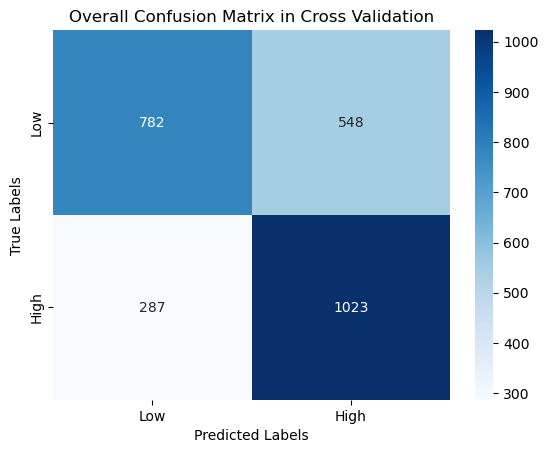

In [64]:
'''
Visualize the overall confusion matrix from the CV
'''
plot_cm(overall_cm1, 'Overall Confusion Matrix in Cross Validation')

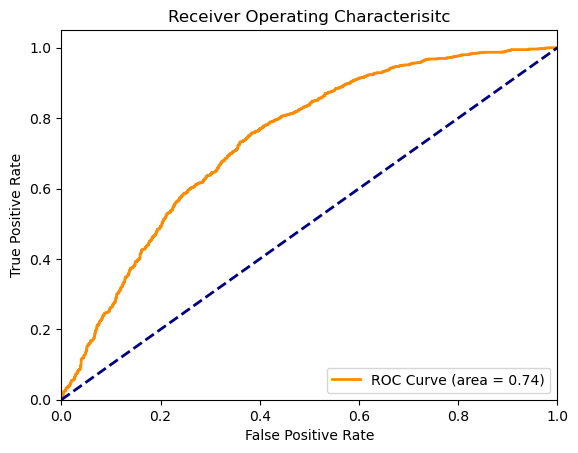

In [65]:
'''
Plot ROC-AUC
'''
plot_roc_auc(overall_labels1, overall_preds1)

max std =  0.0008918118255765409


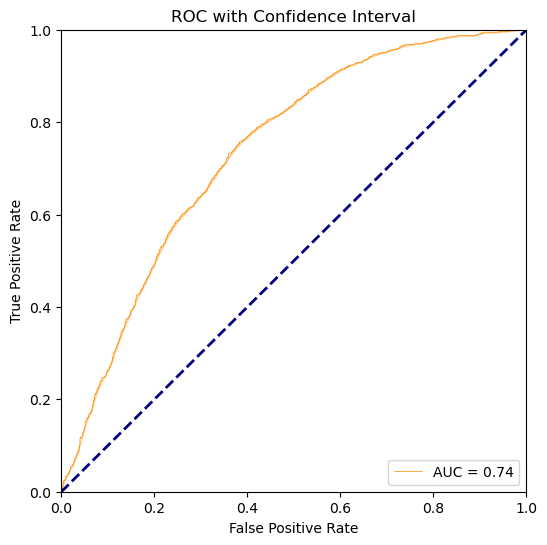

In [81]:
plot_roc_auc_with_CI(overall_labels1, overall_preds1, 1000)

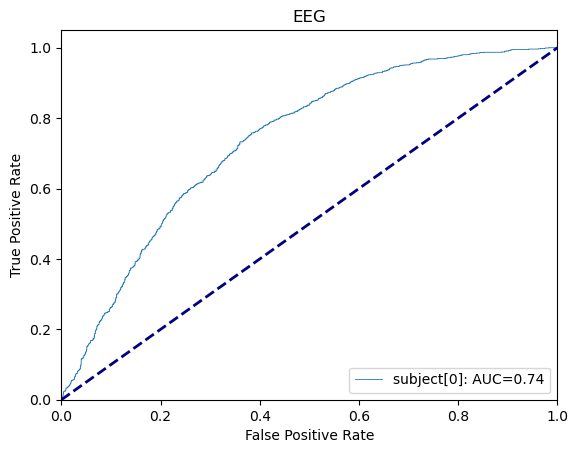

In [82]:
plot_all_roc_with_CI([[overall_preds1, overall_labels1]])

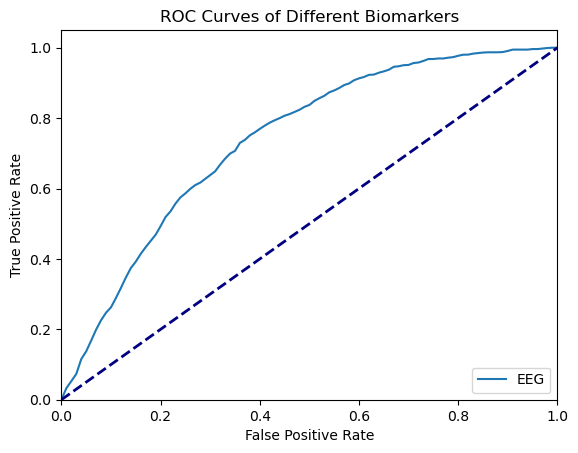

In [91]:
plot_mean_roc_range([[[overall_preds1, overall_labels1]]], f_type_list = ['EEG'])

### Cross Validation (with Scheduler)

In [20]:
'''
Test On Real Data With Cross Validation (With Scheduler)

### Change for better performance
- epochs :
- n_translayer: number of transformer block
- feat_choice : [WordEmbedding, EEG, EyeGaze]
'''
feat_choice = [0, 1, 1] # Use EEG and EyeGaze 
n_translayer = 1
epochs = 300
optimizer_type = 'Adam' # 'Adam' or 'SGD'
avg_acc2, test_acc_list2, overall_cm2, overall_f12, (overall_preds2, overall_labels2) = k_fold_CV(k_fold = 5, 
                              batch_size = 40, epochs = epochs,
                              data = original_data, downsample = True,
                              n_trans = n_translayer, feat_choice = feat_choice,
                              metrics = [total_loss, relevance_accuracy], 
                              opt_type = optimizer_type,
                              lr = 0.05, min_lr = 1e-5,
                              MultiHeaded = True, num_heads = 3, device = device)

At 1-th Fold:
[At Epoch300]: 	-- LastBatchLoss: 0.5575, LastBatchAcc: 0.5750, TestLoss: 0.6926, TestAcc: 0.5985, TestF1: 0.6162
At 2-th Fold:
[At Epoch300]: 	-- LastBatchLoss: 0.6423, LastBatchAcc: 0.6618, TestLoss: 1.0621, TestAcc: 0.6599, TestF1: 0.6767
At 3-th Fold:
[At Epoch300]: 	-- LastBatchLoss: 0.5378, LastBatchAcc: 0.7115, TestLoss: 0.5996, TestAcc: 0.6782, TestF1: 0.6571
At 4-th Fold:
[At Epoch300]: 	-- LastBatchLoss: 0.5938, LastBatchAcc: 0.7458, TestLoss: 0.6700, TestAcc: 0.6072, TestF1: 0.6270
At 5-th Fold:
[At Epoch300]: 	-- LastBatchLoss: 0.5852, LastBatchAcc: 0.7292, TestLoss: 0.6949, TestAcc: 0.5819, TestF1: 0.6237


In [21]:
avg_acc2

0.6251458168029785

In [22]:
overall_f12

0.6382022471910113

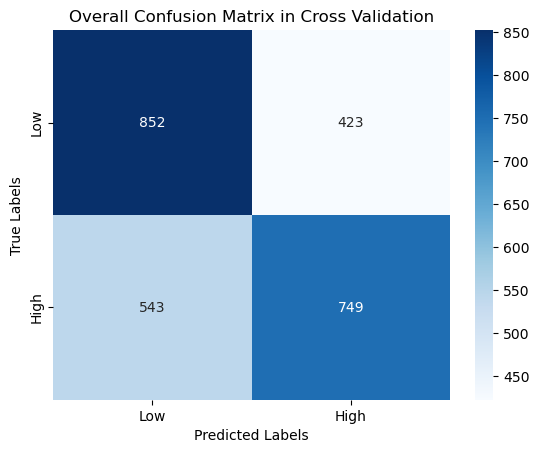

In [23]:
'''
Visualize the overall confusion matrix from the CV
'''
plot_cm(overall_cm2, 'Overall Confusion Matrix in Cross Validation')

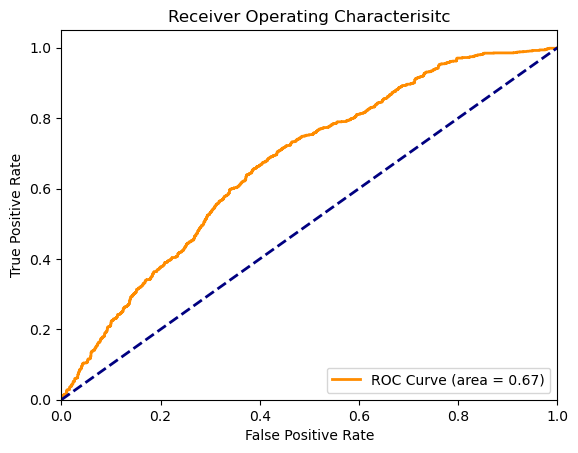

In [24]:
'''
Plot ROC-AUC
'''
plot_roc_auc(overall_labels2, overall_preds2)

----
### ROC-AUC for All Subjects


In [23]:
def get_stats4ROC(feat_choice = [0, 1, 1], n_subs = 9,
                  epochs = 500, optimizer_type = 'Adam', n_translayer = 1, k = 5):
    # Loop Through each Subject:
    avg_acc_list = []
    cm_list = []
    f1_list = []
    pred_label_list = []
    
    # Get Device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    for idx in range(n_subs):
        # Load data
        original_data = load_data(downsample = False, subIdx = idx)
        #embeddings, eeg_features, gaze_features, labels, sen_len = original_data
    
        
        avg_acc, test_acc_list, overall_cm, overall_f1, pred_label = k_fold_CV(k_fold = k, 
                                      batch_size = 16, epochs = epochs,
                                      data = original_data, downsample = True,
                                      n_trans = n_translayer, feat_choice = feat_choice,
                                      metrics = [total_loss, relevance_accuracy], 
                                      opt_type = optimizer_type,                                                                     
                                      lr = 0.05,
                                      MultiHeaded = True, num_heads = 3, device = device)
        avg_acc_list.append(avg_acc)
        cm_list.append(overall_cm)
        f1_list.append(overall_f1)
        pred_label_list.append(pred_label)

    return avg_acc_list, cm_list, f1_list, pred_label_list

In [28]:
# feat_choice = [WordEmbedding, EEG, EyeGaze]
f_choice1 = [0, 1, 0] # EEG only
avg_acc_list1, cm_list1, f1_list1, pred_label_list1 = get_stats4ROC(f_choice1, n_subs = 9,
                                                                   epochs = 500, optimizer_type = 'Adam', n_translayer = 1, k = 5)

At 1-th Fold:
[At Epoch20]: 	-- LastBatchLoss: 1.3872, LastBatchAcc: 0.7647, TestLoss: 1.3446, TestAcc: 0.5038, TestF1: 0.0000
At 2-th Fold:
[At Epoch20]: 	-- LastBatchLoss: 1.3072, LastBatchAcc: 0.6667, TestLoss: 1.3186, TestAcc: 0.6306, TestF1: 0.6799


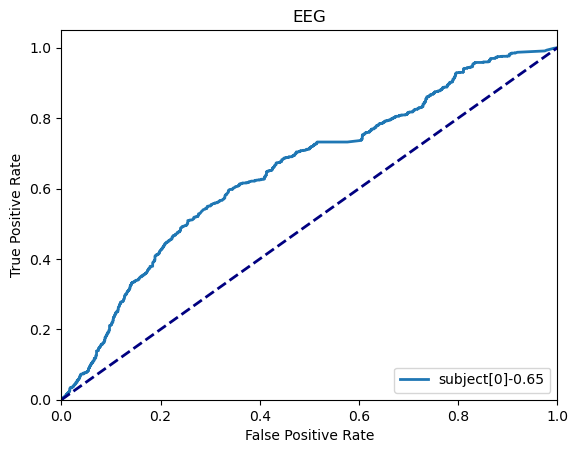

In [29]:
# Plot ROC for EEG
plot_all_roc(pred_label_list1, f_type = 'EEG')

In [ ]:
# feat_choice = [WordEmbedding, EEG, EyeGaze]
f_choice2 = [0, 0, 1] # EyeGaze only
avg_acc_list2, cm_list2, f1_list2, pred_label_list2 = get_stats4ROC(f_choice2, n_subs = 9,
                                                                   epochs = 500, optimizer_type = 'Adam', n_translayer = 1, k = 5)

In [ ]:
# Plot ROC for EyeGaze
plot_all_roc(pred_label_list2, f_type = 'EyeGaze')

In [ ]:
# feat_choice = [WordEmbedding, EEG, EyeGaze]
f_choice3 = [0, 1, 1] # EEG + EyeGaze
avg_acc_list3, cm_list3, f1_list3, pred_label_list3 = get_stats4ROC(f_choice3, n_subs = 9,
                                                                   epochs = 500, optimizer_type = 'Adam', n_translayer = 1, k = 5)

In [ ]:
# Plot ROC for EEG + EyeGaze
plot_all_roc(pred_label_list3, f_type = 'EEG and EyeGaze')

----
### t-SNE on ReadingEmbeddings

In [ ]:
'''
1. Train Model on the whole Dataset
2. Output ReadingEmbeddings
3. Exclude Paddings for ReadingEmbeddings and Labels
4. Apply t-SNE and Plot
'''
# Word Embedding Only
feat_choice = [1, 0, 0] # [WordEmbeddings, EEG, EyeGaze]
epochs = 480

# Initialize Model
mymodel1 = ReadingEmbeddingModel(word_embedding_dim=768, 
                              eeg_feature_dim = 5460,
                              eye_gaze_feature_dim=12, 
                              projection_dim=128,
                              n_trans = 1, 
                              feat_choice = feat_choice,
                              MultiHeaded = True, num_heads = 3)

# Set Device
mymodel1.to(device)
downsampled_data_device = [d.to(device) for d in downsampled_data]

# Train
(loss_list_real, acc_list_real), (test_loss, test_acc1), cm1, f11, (preds, labels, valid_indices) = train_model(mymodel1, batch_size = 16, epochs = epochs,
            train_data = downsampled_data_device, test_data = downsampled_data_device, downsample = False,
            metrics = [total_loss, relevance_accuracy], 
            opt_type = 'Adam',
            lr = 0.05, min_lr = -1) 

In [ ]:
# Train
(loss_list_real, acc_list_real), (test_loss, test_acc1), cm1, f11, (preds, labels, valid_indices) = train_model(mymodel1, batch_size = 16, epochs = epochs,
            train_data = downsampled_data_device, test_data = downsampled_data_device, downsample = False,
            metrics = [total_loss, relevance_accuracy], 
            opt_type = 'SGD',
            lr = 0.03, min_lr = -1) 

In [123]:
# Get ReadingEmbeddings
reading_emb1 = mymodel1.get_reading_embeddings(d_embeddings, d_eeg_features, d_gaze_features).clone().detach()

In [30]:
#re = mymodel.get_reading_embeddings(torch.tensor([[[0]]]), d_eeg_features, torch.tensor([[[0]]])).clone().detach()

In [133]:
lb_no_pad = torch.cat([sen[:l] for sen, l in zip(d_labels, d_sen_len)], dim = 0)

In [125]:
# Remove Paddings
re_no_pad1 = torch.cat([sen[:l] for sen, l in zip(reading_emb1, d_sen_len)], dim = 0)

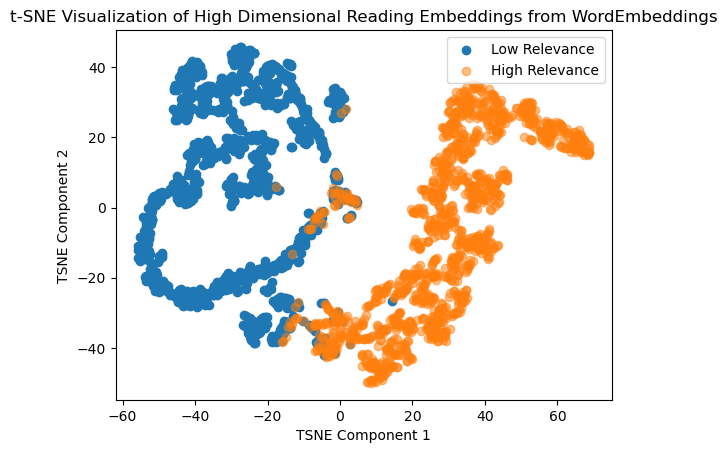

In [126]:
# Plot t-SNE
_ = plot_tsne(re_no_pad1,
             lb_no_pad,
              0.5,
             'Reading Embeddings from WordEmbeddings')

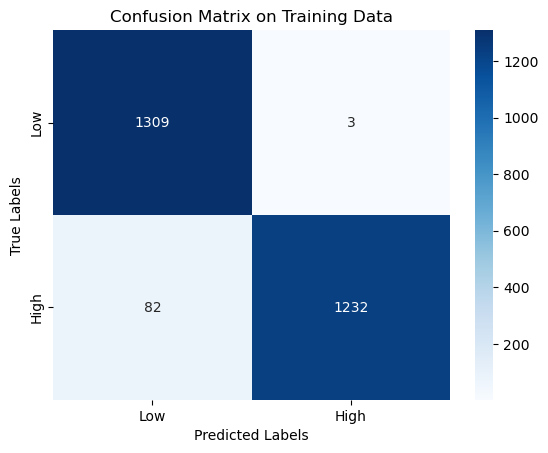

In [114]:
# Plot Confusion Matrix
plot_cm(cm1, 'Confusion Matrix on Training Data')

In [19]:
test_acc1

0.9776260852813721

In [20]:
f11

0.9774378585086041

----

In [27]:
'''
1. Train Model on the whole Dataset
2. Output ReadingEmbeddings
3. Exclude Paddings for ReadingEmbeddings and Labels
4. Apply t-SNE and Plot
'''
# EEG Only
feat_choice = [0, 1, 0] # [WordEmbeddings, EEG, EyeGaze]
epochs = 500

# Initialize Model
mymodel2 = ReadingEmbeddingModel(word_embedding_dim=768, 
                              eeg_feature_dim = 5460,
                              eye_gaze_feature_dim=12, 
                              projection_dim=128,
                              n_trans = 1, 
                              feat_choice = feat_choice,
                              MultiHeaded = True, num_heads = 3)

# Set Device
mymodel2.to(device)
downsampled_data_device = [d.to(device) for d in downsampled_data]

# Train
(loss_list_real, acc_list_real), (test_loss, test_acc2), cm2, f12, (preds, labels, valid_indices) = train_model(mymodel2, batch_size = 16, epochs = epochs,
            train_data = downsampled_data_device, test_data = downsampled_data_device, downsample = False,
            metrics = [total_loss, relevance_accuracy], 
            opt_type = 'Adam',
            lr = 0.05, min_lr = -1) 

[At Epoch500]: 	-- LastBatchLoss: 1.1831, LastBatchAcc: 0.6481, TestLoss: 1.1638, TestAcc: 0.6826, TestF1: 0.6706


In [29]:
# Get ReadingEmbeddings
reading_emb2 = mymodel2.get_reading_embeddings(d_embeddings, d_eeg_features, d_gaze_features).clone().detach()
# Remove Paddings
re_no_pad2 = torch.cat([sen[:l] for sen, l in zip(reading_emb2, d_sen_len)], dim = 0)

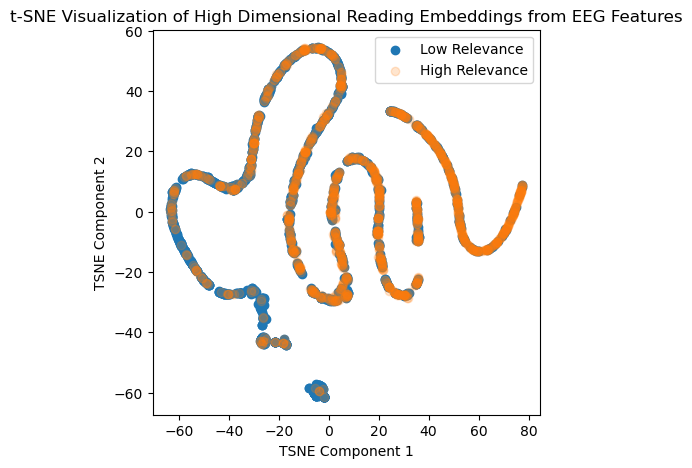

In [33]:
# Plot t-SNE
_ = plot_tsne(re_no_pad2,
             lb_no_pad,
              0.2,
             'Reading Embeddings from EEG Features')

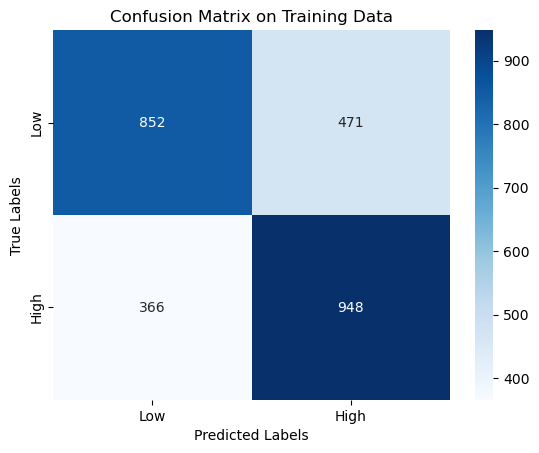

In [28]:
# Plot Confusion Matrix
plot_cm(cm2, 'Confusion Matrix on Training Data')

----

In [ ]:
'''
1. Train Model on the whole Dataset
2. Output ReadingEmbeddings
3. Exclude Paddings for ReadingEmbeddings and Labels
4. Apply t-SNE and Plot
'''
# EyeGaze Only
feat_choice = [0, 0, 1] # [WordEmbeddings, EEG, EyeGaze]
epochs = 500

# Initialize Model
mymodel3 = ReadingEmbeddingModel(word_embedding_dim=768, 
                              eeg_feature_dim = 5460,
                              eye_gaze_feature_dim=12, 
                              projection_dim=128,
                              n_trans = 1, 
                              feat_choice = feat_choice,
                              MultiHeaded = True, num_heads = 3)

# Set Device
mymodel3.to(device)
downsampled_data_device = [d.to(device) for d in downsampled_data]

# Train
(loss_list_real, acc_list_real), (test_loss, test_acc3), cm3, f13, (preds, labels, valid_indices) = train_model(mymodel3, batch_size = 16, epochs = epochs,
            train_data = downsampled_data_device, test_data = downsampled_data_device, downsample = False,
            metrics = [total_loss, relevance_accuracy], 
            opt_type = 'Adam',
            lr = 0.05, min_lr = -1) 

In [ ]:
# Get ReadingEmbeddings
reading_emb3 = mymodel3.get_reading_embeddings(d_embeddings, d_eeg_features, d_gaze_features).clone().detach()
# Remove Paddings
re_no_pad3 = torch.cat([sen[:l] for sen, l in zip(reading_emb3, d_sen_len)], dim = 0)

In [ ]:
# Plot t-SNE
_ = plot_tsne(re_no_pad3,
             lb_no_pad,
              0.2,
             'Reading Embeddings from EyeGaze Features')

In [ ]:
# Plot Confusion Matrix
plot_cm(cm3, 'Confusion Matrix on Training Data')

----

In [130]:
'''
1. Train Model on the whole Dataset
2. Output ReadingEmbeddings
3. Exclude Paddings for ReadingEmbeddings and Labels
4. Apply t-SNE and Plot
'''
# EEG + EyeGaze
feat_choice = [0, 1, 1] # [WordEmbeddings, EEG, EyeGaze]
epochs = 500

# Initialize Model
mymodel4 = ReadingEmbeddingModel(word_embedding_dim=768, 
                              eeg_feature_dim = 5460,
                              eye_gaze_feature_dim=12, 
                              projection_dim=128,
                              n_trans = 1, 
                              feat_choice = feat_choice,
                              MultiHeaded = True, num_heads = 3)

# Set Device
mymodel4.to(device)
downsampled_data_device = [d.to(device) for d in downsampled_data]

# Train
(loss_list_real, acc_list_real), (test_loss, test_acc4), cm4, f14, (preds, labels, valid_indices) = train_model(mymodel4, batch_size = 16, epochs = epochs,
            train_data = downsampled_data_device, test_data = downsampled_data_device, downsample = False,
            metrics = [total_loss, relevance_accuracy], 
            opt_type = 'Adam',
            lr = 0.05, min_lr = -1) 

[At Epoch500]: 	-- LastBatchLoss: 1.4600, LastBatchAcc: 0.6863, TestLoss: 1.2282, TestAcc: 0.6498, TestF1: 0.7172


In [134]:
# Get ReadingEmbeddings
reading_emb4 = mymodel4.get_reading_embeddings(d_embeddings, d_eeg_features, d_gaze_features).clone().detach()
# Remove Paddings
re_no_pad4 = torch.cat([sen[:l] for sen, l in zip(reading_emb4, d_sen_len)], dim = 0)

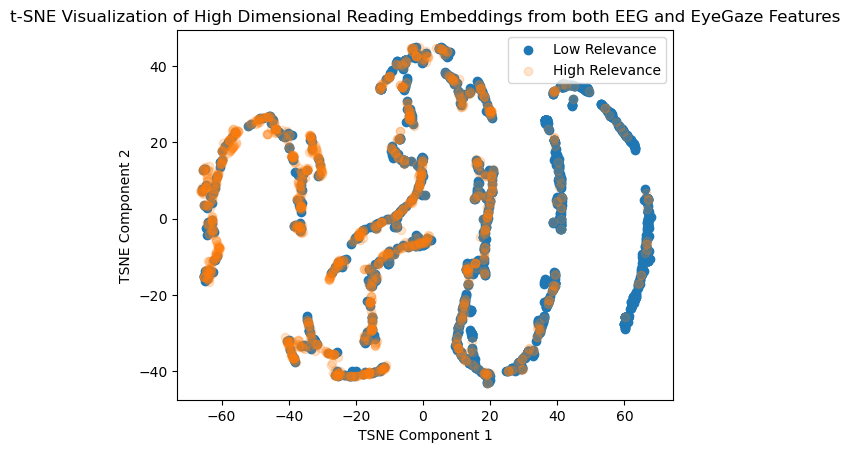

In [135]:
# Plot t-SNE
_ = plot_tsne(re_no_pad4,
             lb_no_pad,
              0.2,
             'Reading Embeddings from both EEG and EyeGaze Features')

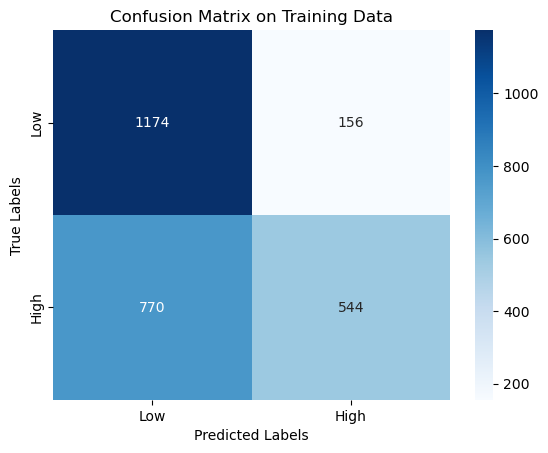

In [136]:
# Plot Confusion Matrix
plot_cm(cm4, 'Confusion Matrix on Training Data')

----
### Visualization Section

In [31]:
'''
Confusion Matrix of the Model Predictions
'''
def plot_confusionMatrix(model, train_data, senIdx = -1):
    '''
    Plot the Confusion Matrix for a Specific Sentence / the Whole Data
    - model:
    - train_data:
        - word_embeddings : [n_sentences, n_words, embedding_dim]
        - eeg_features    : [num_sentences, max_num_words, eeg_feature_size = 5460]
        - gaze_features   : [n_sentences, n_words, feature_dim = 12]
        - true_labels: [n_sentences, n_words] 
        - sen_lengths: [n_sentences]
    - index: index of the sentence, -1 for the whole data
    '''
    embeddings, eeg_features, gaze_features, labels, sen_len = train_data
    preds = model(embeddings, eeg_features, gaze_features).clone().detach()
    true_labels, sen_len = train_data[-2:]
    
    if -1 == senIdx:
        max_num_words = sen_len.max()
        n_sen = len(sen_len)
        
        # Flatten predicitons and labels, excluding padding
        valid_indices = torch.arange(max_num_words).expand(n_sen, max_num_words) < sen_len.unsqueeze(1)
        masked_preds = (preds[valid_indices] >= 0.5).int()
        masked_labels = true_labels[valid_indices]

        # Confusion Matrix
        cm = confusion_matrix(masked_labels.numpy(), masked_preds.numpy())
        title_str = f'Confusion Matrix for All Sentences'
    else:     
        # Get the Predictions and Labels at the Index
        senLenAtIdx = sen_len[senIdx]
        predAtIdx = (preds[senIdx, :senLenAtIdx] >= 0.5).int()
        labelAtIdx = true_labels[senIdx, :senLenAtIdx]
        
        # Confusion matrix
        cm = confusion_matrix(labelAtIdx, predAtIdx)
        title_str = f'Confusion Matrix for Sentence [{senIdx}]'
        
    # Plotting
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot = True, ax = ax, fmt = 'g', cmap = 'Blues')
    
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title(title_str)
    ax.xaxis.set_ticklabels(['Low', 'High'])
    ax.yaxis.set_ticklabels(['Low', 'High'])
    
    plt.show()

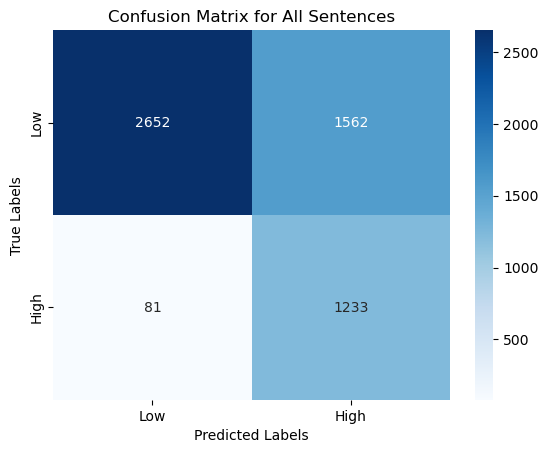

In [32]:
# for all sentences
plot_confusionMatrix(mymodel, original_data, senIdx = -1)

In [33]:
'''
F1 Score = TP / (TP + 0.5 * (FP + FN))
'''
def f1_score_REC(model, train_data, senIdx = -1):
    '''
    Calculate the F1 Score for a Specific Sentence / the Whole Data
    - model:
    - train_data:
        - word_embeddings : [n_sentences, n_words, embedding_dim]
        - eeg_features    : [num_sentences, max_num_words, eeg_feature_size = 5460]
        - gaze_features   : [n_sentences, n_words, feature_dim = 12]
        - true_labels: [n_sentences, n_words] 
        - sen_lengths: [n_sentences]
    - index: index of the sentence, -1 for the whole data
    '''
    embeddings, eeg_features, gaze_features, labels, sen_len = train_data
    preds = model(embeddings, eeg_features, gaze_features).clone().detach()
    true_labels, sen_len = train_data[-2:]
    
    if -1 == senIdx:
        max_num_words = sen_len.max()
        n_sen = len(sen_len)
        
        # Flatten predicitons and labels, excluding padding
        valid_indices = torch.arange(max_num_words).expand(n_sen, max_num_words) < sen_len.unsqueeze(1)
        masked_preds = (preds[valid_indices] >= 0.5).int().flatten()
        masked_labels = true_labels[valid_indices].flatten()

    else:     
        # Get the Predictions and Labels at the Index
        senLenAtIdx = sen_len[senIdx]
        masked_preds = (preds[senIdx, :senLenAtIdx] >= 0.5).int().flatten()
        masked_labels = true_labels[senIdx, :senLenAtIdx].flatten()
        
    # F1 Score
    return f1_score(masked_labels, masked_preds)
        

In [34]:
f1_score_REC(mymodel, original_data, senIdx = -1)

0.6001460209296666

### Scratch Section

In [14]:
'''
Initializing the Model
'''


mymodel = ReadingEmbeddingModel(word_embedding_dim=768, 
                              eeg_feature_dim = 5460,
                              eye_gaze_feature_dim=12, 
                              projection_dim=128,
                              n_trans = 1, 
                              feat_choice = [0, 1, 1],
                              MultiHeaded = True, num_heads = 3)

# Get Reading Embedding
#reading_embeddings = mymodel.get_reading_embeddings(embeddings, gaze_features).clone().detach()
# Get Classifications
#pred_labels = mymodel(embeddings, gaze_features).clone().detach()

In [19]:
'''
Train Mode 1: ### Preferred but DO NOT USE
The same downsampled data for each epoch 
'''
mymodel = ReadingEmbeddingModel(word_embedding_dim=768, 
                              eeg_feature_dim = 5460,
                              eye_gaze_feature_dim=12, 
                              projection_dim=128,
                              n_trans = 1, 
                              feat_choice = [0, 1, 1],
                              MultiHeaded = True, num_heads = 3)

# epochs > 150
(loss_list_real, acc_list_real), (test_loss, test_acc), cm1, f11, (preds, labels, valid_indices) = train_model(mymodel, batch_size = 16, epochs = 200,
            train_data = downsampled_data, test_data = original_data, downsample = False,
            metrics = [masked_bce_loss, relevance_accuracy], 
            opt_type = 'Adam',
            lr = 0.05, min_lr = -1) 

[At Epoch200]: 	-- LastBatchLoss: 0.8390, LastBatchAcc: 0.4902, TestLoss: 0.9310, TestAcc: 0.3039, TestF1: 0.1671


In [ ]:
'''
Train Mode 2: ### DO NOT USE
Randomly Downsample the training data for each epoch - High stochasticity
'''
mymodel = ReadingEmbeddingModel(word_embedding_dim=768, 
                              eeg_feature_dim = 5460,
                              eye_gaze_feature_dim=12, 
                              projection_dim=128,
                              n_trans = 1, 
                              feat_choice = [0, 1, 1],
                              MultiHeaded = True, num_heads = 3)

# epochs > 150
(loss_list_real, acc_list_real), (test_loss, test_acc), cm2, f12, (preds, labels, valid_indices)  = train_model(mymodel, batch_size = 16, epochs = 200,
            train_data = original_data, test_data = original_data, downsample = True,
            metrics = [masked_bce_loss, relevance_accuracy], 
            opt_type = 'Adam',
            lr = 0.05, min_lr = 1e-5) 

In [ ]:
# Get the predicted Labels (for visualizations)
preds = mymodel(embeddings, eeg_features, gaze_features).clone().detach()

In [ ]:
# Get the Reading Embedding
REmbeddings = mymodel.get_reading_embeddings(embeddings, eeg_features, gaze_features).clone().detach()